In [1]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms, models
import matplotlib.cm
from torchinfo import summary
import copy
import cv2
import matplotlib.pyplot as plt
from argparse import ArgumentParser

from mmdet.apis import (inference_detector,
                        init_detector, show_result_pyplot)

/root/anaconda3/envs/openmmlab/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
device = 'cpu'

config = r"../work_dirs/Compare_Detection/yolov3_d53_960_273e_WSJ_coco_0.828/yolov3_d53_960_273e_WSJ_coco.py"
ckpt = r"../work_dirs/Compare_Detection/yolov3_d53_960_273e_WSJ_coco_0.828/epoch_28.pth"
img = r"../data/WSJ_2_coco/val2014/10.jpg"
score_thr = 0.5

# build the model from a config file and a checkpoint file
model = init_detector(config, ckpt, device=device)

# # 定义列表用于存储中间层的输入或者输出
# module_name = []
# p_in = []
# p_out = []

# image = Image.open(img)

load checkpoint from local path: ../work_dirs/Compare_Detection/yolov3_d53_960_273e_WSJ_coco_0.828/epoch_28.pth


In [7]:
summary(model)

Layer (type:depth-idx)                        Param #
YOLOV3                                        --
├─Darknet: 1-1                                --
│    └─ConvModule: 2-1                        --
│    │    └─Conv2d: 3-1                       864
│    │    └─BatchNorm2d: 3-2                  64
│    │    └─LeakyReLU: 3-3                    --
│    └─Sequential: 2-2                        --
│    │    └─ConvModule: 3-4                   18,560
│    │    └─ResBlock: 3-5                     20,672
│    └─Sequential: 2-3                        --
│    │    └─ConvModule: 3-6                   73,984
│    │    └─ResBlock: 3-7                     82,304
│    │    └─ResBlock: 3-8                     82,304
│    └─Sequential: 2-4                        --
│    │    └─ConvModule: 3-9                   295,424
│    │    └─ResBlock: 3-10                    328,448
│    │    └─ResBlock: 3-11                    328,448
│    │    └─ResBlock: 3-12                    328,448
│    │    └─ResBlock: 3

In [5]:
def got_shape(x):
    if type(x) == torch.Tensor:
        return x.shape
    elif type(x) in [list, tuple]:
        return [got_shape(i) for i in x]
    else: 
        return None
        
# 定义hook_fn，顾名思义就是把数值从
def forward_wrapper(name):
    def forward_hook(module, input, output):
        # print(f"module name:{name}, input shape:{got_shape(input)}, output shape:{got_shape(output)}")
        module_name.append(name)
        p_in.append(input)
        p_out.append(output)
    return forward_hook

def normalize_img(heat_map):
    heat_map = (heat_map - np.min(heat_map)) / (np.max(heat_map) - np.min(heat_map))
    heat_map = np.uint8(255 * heat_map)  # 将热力图转换为RGB格式,0-255,heatmap0显示红色为关注区域，如果用heatmap则蓝色是关注区域
    heat_map = cv2.applyColorMap(heat_map, cv2.COLORMAP_JET)  
    return heat_map[:,:,::-1]

def fuse_feature_and_img(heat_map, img):
    heat_map = cv2.resize(heat_map,(480,480))
    heat_map = normalize_img(heat_map)
    img = np.array(img)
    img = cv2.resize(img,(480,480))
    result = heat_map * 1 + img * 0
    result = np.uint8(result)
    return result

In [4]:
# 注册钩子
for name, module in model.named_modules():
    module.register_forward_hook(forward_wrapper(name))

# 推理结果
result = inference_detector(model, img)

/opt/data/private/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


In [34]:
type(model.backbone.stem.conv.activate)

mmcv.cnn.bricks.swish.Swish

In [5]:
# from matplotlib import pyplot as plt
# import numpy as np
# # 取出结果
# stage_in = []
# stage_out = []
# for i in range(1,5):
#     stage_in.append(p_in[module_name.index(f'backbone.layer{i}')][0].numpy())
#     stage_out.append(p_out[module_name.index(f'backbone.layer{i}')][0].numpy())

# for i in range(4):
#     heat_map = np.max(stage_in[i].squeeze(),0)
#     heat_map = normalize_img(heat_map)
#     plt.imshow(heat_map)
#     plt.show()

In [6]:
module_name

['backbone.conv1',
 'backbone.bn1',
 'backbone.relu',
 'backbone.maxpool',
 'backbone.layer1.0.conv1',
 'backbone.layer1.0.bn1',
 'backbone.layer1.0.relu',
 'backbone.layer1.0.conv2',
 'backbone.layer1.0.bn2',
 'backbone.layer1.0.relu',
 'backbone.layer1.0.gen_attention_block.kv_downsample',
 'backbone.layer1.0.gen_attention_block.key_conv',
 'backbone.layer1.0.gen_attention_block.value_conv',
 'backbone.layer1.0.gen_attention_block.proj_conv',
 'backbone.layer1.0.gen_attention_block',
 'backbone.layer1.0.conv3',
 'backbone.layer1.0.bn3',
 'backbone.layer1.0.context_block.conv_mask',
 'backbone.layer1.0.context_block.softmax',
 'backbone.layer1.0.context_block.channel_add_conv.0',
 'backbone.layer1.0.context_block.channel_add_conv.1',
 'backbone.layer1.0.context_block.channel_add_conv.2',
 'backbone.layer1.0.context_block.channel_add_conv.3',
 'backbone.layer1.0.context_block.channel_add_conv',
 'backbone.layer1.0.context_block',
 'backbone.layer1.0.downsample.0',
 'backbone.layer1.0.d

In [11]:
check1 = p_out[module_name.index(f'backbone.layer1.1.gen_attention_block.proj_conv')][0].numpy()
heat_map = check1.squeeze()
results = fuse_feature_and_img(heat_map, image)
plt.axis('off')
plt.imshow(results)
plt.savefig(f'proj_out.svg',dpi=600, bbox_inches='tight')
plt.savefig(f'proj_out.pdf',dpi=600, bbox_inches='tight')
plt.clf()
plt.close()

In [ ]:
# 拿出来key和value部分的输出
check1 = p_out[module_name.index(f'backbone.layer1.1.gen_attention_block.key_conv')][0].numpy()
check2 = p_out[module_name.index(f'backbone.layer1.1.gen_attention_block.value_conv')][0].numpy()


heat_map = np.max(check1.squeeze(),0)
results = fuse_feature_and_img(heat_map, image)
plt.axis('off')
plt.imshow(results)
plt.savefig(f'key_out.svg',dpi=600, bbox_inches='tight')
plt.savefig(f'key_out.pdf',dpi=600, bbox_inches='tight')
plt.clf()
plt.close()
heat_map = np.max(check2.squeeze(),0)
results = fuse_feature_and_img(heat_map, image)
plt.axis('off')
plt.imshow(results)
plt.savefig(f'value_out.svg',dpi=600, bbox_inches='tight')
plt.savefig(f'value_out.pdf',dpi=600, bbox_inches='tight')
plt.clf()
plt.close()


In [6]:
# 拿出每个backbone_stage的输入和输出
block_in = []
block_out = []

for i in range(1,5):
    # block_in.append(p_in[module_name.index(f'backbone.layer{i}.2.gen_attention_block.kv_downsample')][0].numpy())
    # block_out.append(p_in[module_name.index(f'backbone.layer{i}.2.context_block')][0].numpy())
    block_in.append(p_in[module_name.index(f'backbone.layer{i}')][0].numpy())
    block_out.append(p_out[module_name.index(f'backbone.layer{i}')][0].numpy())

for i in range(4):
    heat_map = np.max(block_in[i].squeeze(),0)
    results = fuse_feature_and_img(heat_map, image)
    plt.axis('off')
    plt.imshow(results)
    plt.savefig(f'stage_in_{i}.svg',dpi=600, bbox_inches='tight')
    plt.savefig(f'stage_in_{i}.pdf',dpi=600, bbox_inches='tight')
    plt.clf()
    plt.close()
    heat_map = np.max(block_out[i].squeeze(),0)
    results = fuse_feature_and_img(heat_map, image)
    plt.axis('off')
    plt.imshow(results)
    plt.savefig(f'stage_out_{i}.svg',dpi=600, bbox_inches='tight')
    plt.savefig(f'stage_out_{i}.pdf',dpi=600, bbox_inches='tight')
    plt.clf()
    plt.close()


In [14]:
# plt.figure(figsize=(10,10))
# for i in range(4):
#     heat_map = np.max(block_in[i].squeeze(),0)
#     results = fuse_feature_and_img(heat_map, image)
#     plt.axis('off')
#     plt.imshow(results)
#     plt.savefig(f'perception_in_{i}.svg',dpi=600, bbox_inches='tight')
#     plt.savefig(f'perception_in_{i}.pdf',dpi=600, bbox_inches='tight')
#     plt.clf()
#     plt.close()
#     heat_map = np.max(block_out[i].squeeze(),0)
#     results = fuse_feature_and_img(heat_map, image)
#     plt.axis('off')
#     plt.imshow(results)
#     plt.savefig(f'perception_out_{i}.svg',dpi=600, bbox_inches='tight')
#     plt.savefig(f'perception_out_{i}.pdf',dpi=600, bbox_inches='tight')
#     plt.clf()
#     plt.close()

In [41]:
bbox_result, segm_result = result, None
bboxes = np.vstack(bbox_result)
labels = [np.full(bbox.shape[0], i, dtype=np.int32) for i, bbox in enumerate(bbox_result)]
labels = np.concatenate(labels)
labels_text = [model.CLASSES[i] for i in labels]

In [42]:
x = bboxes[:, 0]
y = bboxes[:, 1]
width = bboxes[:, 2] - bboxes[:, 0]
height = bboxes[:, 3] - bboxes[:, 1]

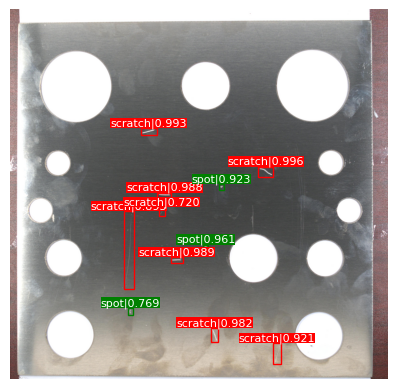

In [64]:
label_colors = ['r', 'g', 'b']
plt.imshow(image)
plt.axis('off')
for i in range(len(x)):
    if bboxes[i, -1] > 0.5:
        plt.gca().add_patch(plt.Rectangle(xy=(x[i], y[i]), width=width[i], height=height[i], edgecolor=label_colors[labels[i]], fill=None))
        plt.text(x[i]+0.5*width[i], y[i], f"{labels_text[i]}|{bboxes[i,-1]:.3f}", verticalalignment="bottom", horizontalalignment="center", color='w', fontsize=8, bbox=dict(boxstyle='square,pad=0', fc=label_colors[labels[i]],lw=0))